Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.7.3
IPython 7.9.0

torch 1.3.0


- Runs on CPU or GPU (if available)

# Autoencoder (MNIST) + Scikit-Learn Random Forest Classifier

A simple, single-hidden-layer, fully-connected autoencoder that compresses 768-pixel MNIST images into 32-pixel vectors (32-times smaller representations). A random forest classifier is then trained for predicting the class labels based on that 32-pixel compressed space.

## Imports

In [2]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True


##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 123
learning_rate = 0.005
num_epochs = 5
batch_size = 256

# Architecture
num_features = 784
num_hidden_1 = 32


##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Device: cuda:0
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


## Model

In [3]:
##########################
### MODEL
##########################

class Autoencoder(torch.nn.Module):

    def __init__(self, num_features):
        super(Autoencoder, self).__init__()
        
        ### ENCODER
        
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        # The following to lones are not necessary, 
        # but used here to demonstrate how to access the weights
        # and use a different weight initialization.
        # By default, PyTorch uses Xavier/Glorot initialization, which
        # should usually be preferred.
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        
        ### DECODER
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_features)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        
    def encoder(self, x):
        encoded = self.linear_1(x)
        encoded = F.leaky_relu(encoded)
        return encoded
    
    def decoder(self, encoded_x):
        logits = self.linear_2(encoded_x)
        decoded = torch.sigmoid(logits)
        return decoded
        

    def forward(self, x):
        
        ### ENCODER
        encoded = self.encoder(x)
        
        ### DECODER
        decoded = self.decoder(encoded)
        
        return decoded

    
torch.manual_seed(random_seed)
model = Autoencoder(num_features=num_features)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [4]:
## Training

In [5]:
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        decoded = model(features)
        cost = F.binary_cross_entropy(decoded, features)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/005 | Batch 000/235 | Cost: 0.7100
Epoch: 001/005 | Batch 050/235 | Cost: 0.2026
Epoch: 001/005 | Batch 100/235 | Cost: 0.1635
Epoch: 001/005 | Batch 150/235 | Cost: 0.1349
Epoch: 001/005 | Batch 200/235 | Cost: 0.1301
Time elapsed: 0.11 min
Epoch: 002/005 | Batch 000/235 | Cost: 0.1238
Epoch: 002/005 | Batch 050/235 | Cost: 0.1131
Epoch: 002/005 | Batch 100/235 | Cost: 0.1099
Epoch: 002/005 | Batch 150/235 | Cost: 0.1062
Epoch: 002/005 | Batch 200/235 | Cost: 0.1035
Time elapsed: 0.22 min
Epoch: 003/005 | Batch 000/235 | Cost: 0.1009
Epoch: 003/005 | Batch 050/235 | Cost: 0.0977
Epoch: 003/005 | Batch 100/235 | Cost: 0.0983
Epoch: 003/005 | Batch 150/235 | Cost: 0.0975
Epoch: 003/005 | Batch 200/235 | Cost: 0.0937
Time elapsed: 0.33 min
Epoch: 004/005 | Batch 000/235 | Cost: 0.0946
Epoch: 004/005 | Batch 050/235 | Cost: 0.0961
Epoch: 004/005 | Batch 100/235 | Cost: 0.0960
Epoch: 004/005 | Batch 150/235 | Cost: 0.0972
Epoch: 004/005 | Batch 200/235 | Cost: 0.0899
Time elapse

## Evaluation

### Training Dataset

Image batch dimensions: torch.Size([15, 1, 28, 28])
Image label dimensions: torch.Size([15])


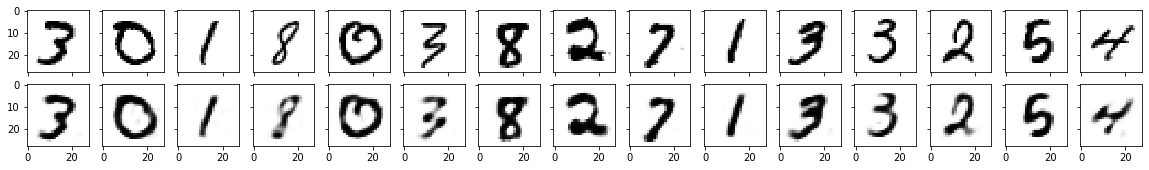

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=15, 
                          shuffle=True)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
# =============================================================

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')

Image batch dimensions: torch.Size([15, 1, 28, 28])
Image label dimensions: torch.Size([15])


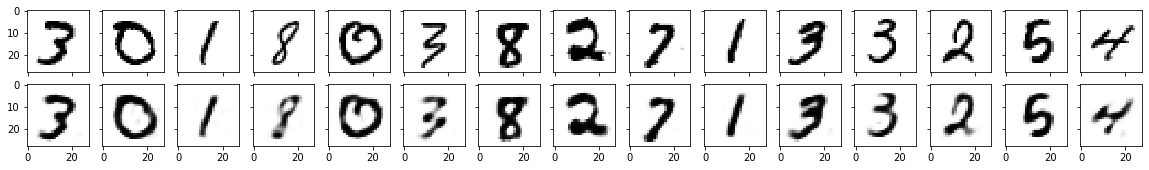

In [7]:
test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=15, 
                         shuffle=True)

# Checking the dataset
for images, labels in test_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
# =============================================================

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')

## Scikit-learn Classifier

### On Original MNIST

In [8]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=60000, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=10000, 
                          shuffle=False)

In [9]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

X_train = np.array(images.reshape(60000, 28*28))
y_train = np.array(labels)


for images, labels in test_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

X_test = np.array(images.reshape(10000, 28*28))
y_test = np.array(labels)

Image batch dimensions: torch.Size([60000, 1, 28, 28])
Image label dimensions: torch.Size([60000])
Image batch dimensions: torch.Size([10000, 1, 28, 28])
Image label dimensions: torch.Size([10000])


In [10]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1).fit(X_train, y_train)
print(f'Train Accuracy: {rf.score(X_train, y_train)*100}%')
print(f'Test Accuracy: {rf.score(X_test, y_test)*100}%')

Train Accuracy: 100.0%
Test Accuracy: 97.09%


### Using PCA

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=32)  # same size as autoencoder latent space
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [13]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1).fit(X_train_pca, y_train)
print(f'Train Accuracy: {rf.score(X_train_pca, y_train)*100}%')
print(f'Test Accuracy: {rf.score(X_test_pca, y_test)*100}%')

Train Accuracy: 100.0%
Test Accuracy: 95.7%


### Compressed MNIST

In [14]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=1000, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=1000, 
                          shuffle=False)

In [15]:
X_train_compr = np.ones((60000, num_hidden_1))
y_train = np.ones(60000)

start_idx = 0

for idx, (images, labels) in enumerate(train_loader): 
    features = images.view(-1, 28*28).to(device)
    decoded = model.encoder(features)
    X_train_compr[start_idx:start_idx+1000] = decoded.to(torch.device('cpu')).detach().numpy()
    y_train[start_idx:start_idx+1000] = labels
    start_idx += 1000

In [16]:
X_test_compr = np.ones((10000, num_hidden_1))
y_test = np.ones(10000)

start_idx = 0

for idx, (images, labels) in enumerate(test_loader): 
    features = images.view(-1, 28*28).to(device)
    decoded = model.encoder(features)
    X_test_compr[start_idx:start_idx+1000] = decoded.to(torch.device('cpu')).detach().numpy()
    y_test[start_idx:start_idx+1000] = labels
    start_idx += 1000

In [17]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1).fit(X_train_compr, y_train)
print(f'Train Accuracy: {rf.score(X_train_compr, y_train)*100}%')
print(f'Test Accuracy: {rf.score(X_test_compr, y_test)*100}%')

Train Accuracy: 100.0%
Test Accuracy: 95.23%


In [18]:
%watermark -iv

torch       1.3.0
torchvision 0.4.1a0+d94043a
numpy       1.17.2
matplotlib  3.1.0

